# Allye Data Science Technical Assessment
## Electricity Demand Forecasting & Battery Dispatch Optimisation


This project aims to develop a short-term electricity demand forecast and use it to optimise battery operation against dynamic tariffs. The core goal is to minimise grid import costs, while respecting physical constraints of the battery system.

The analysis is performed on half-hourly consumption data covering April–October 2023. The dataset exhibits strong time-dependent patterns: a repeatable daily profile, weekday/weekend differences, and clear autocorrelation.

We evaluate a gradient-boosted tree model (XGBoost) against naïve benchmarks, and use the forecasted demand to solve a linear optimisation problem that controls battery charge/discharge behaviour. The optimisation respects battery state of charge, power limits, and a no-export constraint.

Structure:
- Exploratory Data analysis
- Forecasting Demand
- Battery optimisation


### Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import cvxpy as cp

### Import Data

In [2]:
demand_df=pd.read_csv(r'data\assessment_demand_data.csv')
tariff_df=pd.read_csv(r'data\assessment_tariff_data.csv')

demand_df['period_starting']=pd.to_datetime(demand_df['period_starting'])
tariff_df['period_starting']=pd.to_datetime(tariff_df['period_starting'])

demand_df = demand_df.set_index('period_starting').sort_index()
tariff_df = tariff_df.set_index('period_starting').sort_index()

In [3]:
print(demand_df.head())
print(tariff_df.head())

                     mean_demand_kw
period_starting                    
2023-04-01 00:00:00           216.0
2023-04-01 00:30:00           225.0
2023-04-01 01:00:00           221.0
2023-04-01 01:30:00           207.0
2023-04-01 02:00:00           216.0
                     price_pence_per_kwh
period_starting                         
2023-10-01 00:00:00                   21
2023-10-01 00:30:00                   21
2023-10-01 01:00:00                   21
2023-10-01 01:30:00                   21
2023-10-01 02:00:00                   21


## EDA

##### Big picture

- Seems to have daily cycle. 

- Notable dip in July, not seen in other warm periods → unlikely HVAC-related → likely operational or holiday disruption.

- Variation over time suggests moderate seasonality or site usage changes, not random noise.

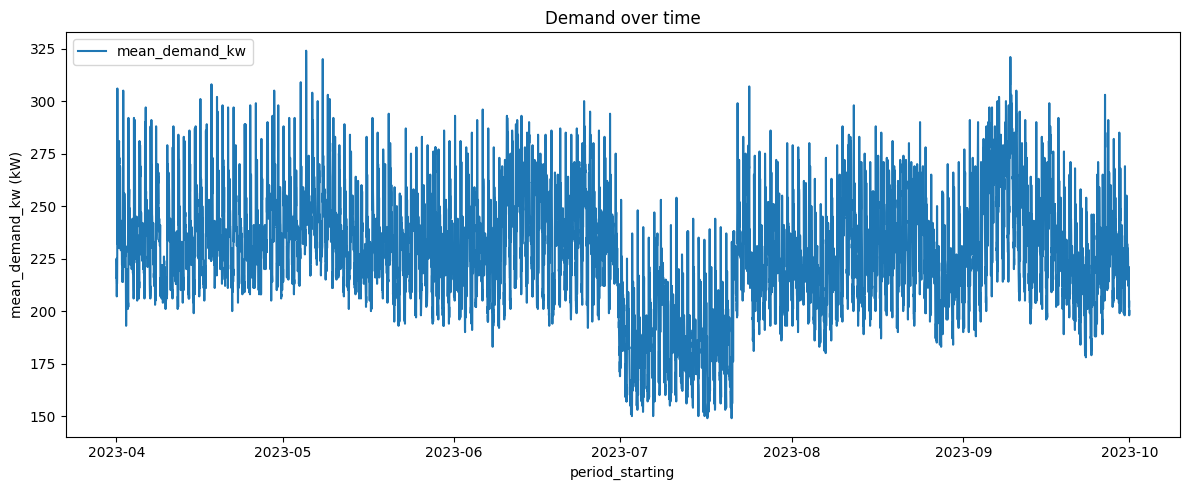

In [4]:
d = demand_df.copy()
DEMAND_COL="mean_demand_kw"


plt.figure(figsize=(12,5))
plt.plot(d.index, d[DEMAND_COL], label='mean_demand_kw')
plt.xlabel('period_starting')
plt.ylabel('mean_demand_kw (kW)')
plt.title('Demand over time')
plt.legend()
plt.tight_layout()
plt.show()

##### Average Daily Demand
- Overnight demand is low and stable (~200–210 kW).
- A sharp increase occurs around 04:00–04:30, peaking above 250 kW.
- After the early ramp, demand settles into a high daytime band (~235–245 kW).
- A gradual decline begins after 18:00, tapering back toward overnight levels.


In [5]:
def add_slot_flags(df):
    # function for adding slot, is weekend and day of week flags.
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have DatetimeIndex — run ensure_datetime_index first")
    df["slot"] = df.index.hour * 2 + (df.index.minute // 30)
    df["is_weekend"] = df.index.dayofweek >= 5
    df["dayofweek"] = df.index.dayofweek
    return df

d=add_slot_flags(d)

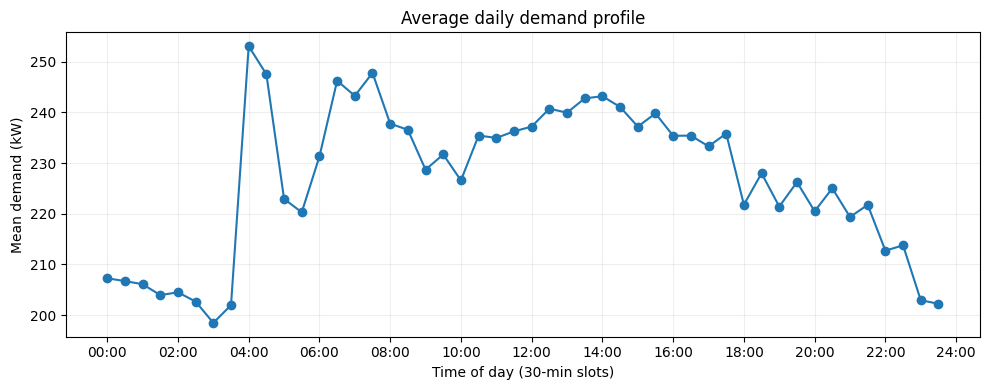

In [6]:


def plot_time_of_day(df, demand_col=DEMAND_COL, figsize=(10,4)):
    prof = d.groupby("slot")[demand_col].mean()
    plt.figure(figsize=figsize)
    plt.plot(prof.index, prof.values, marker="o")
    plt.xticks(range(0,49,4), [f"{h:02d}:00" for h in range(0,25,2)])
    plt.xlabel("Time of day (30-min slots)")
    plt.ylabel("Mean demand (kW)")
    plt.title("Average daily demand profile")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

plot_time_of_day(d)

##### Weekday vs Weekend demand

- Overnight demand is similar for both groups (~200–210 kW).
- Weekdays show a much sharper morning surge around 04:00–05:00, peaking above 260 kW.
- Weekend mornings ramp more gradually and reach lower peak levels (~235–245 kW).
- During daytime (08:00–17:00), weekends maintain a slightly higher and flatter profile than weekdays.
- Evening demand declines earlier on weekends and remains lower from ~18:00 onward.


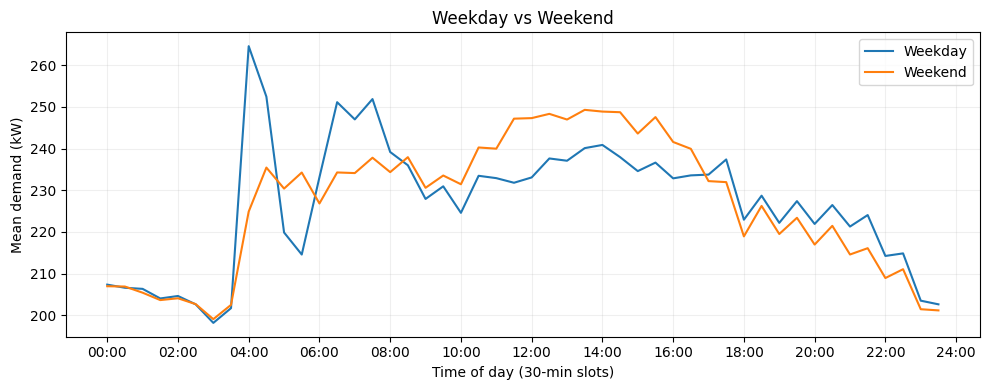

In [7]:
def compare_weekday_weekend(df, demand_col=DEMAND_COL, figsize=(10,4)):
    prof = d.groupby(["is_weekend","slot"])[demand_col].mean().reset_index()
    plt.figure(figsize=figsize)
    for flag,label in [(False,"Weekday"),(True,"Weekend")]:
        sub = prof[prof["is_weekend"]==flag]
        plt.plot(sub["slot"], sub[demand_col], label=label)
    plt.xticks(range(0,49,4), [f"{h:02d}:00" for h in range(0,25,2)])
    plt.xlabel("Time of day (30-min slots)")
    plt.ylabel("Mean demand (kW)")
    plt.title("Weekday vs Weekend")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

compare_weekday_weekend(d)

##### Day-of-week demand profiles

- All weekdays show a very similar shape, with a sharp increase around 04:00–05:00 followed by a high daytime operating band.
- Saturday follows the same pattern but at a higher overall level, particularly midday and early afternoon.
- Sunday demand is noticeably flatter, with a weaker morning ramp.
- Evening demand decreases across all days, with Sunday declining earliest and most strongly.
- Overall, weekday variability is modest, while weekend behaviour is structurally different, especcialy Sunday.


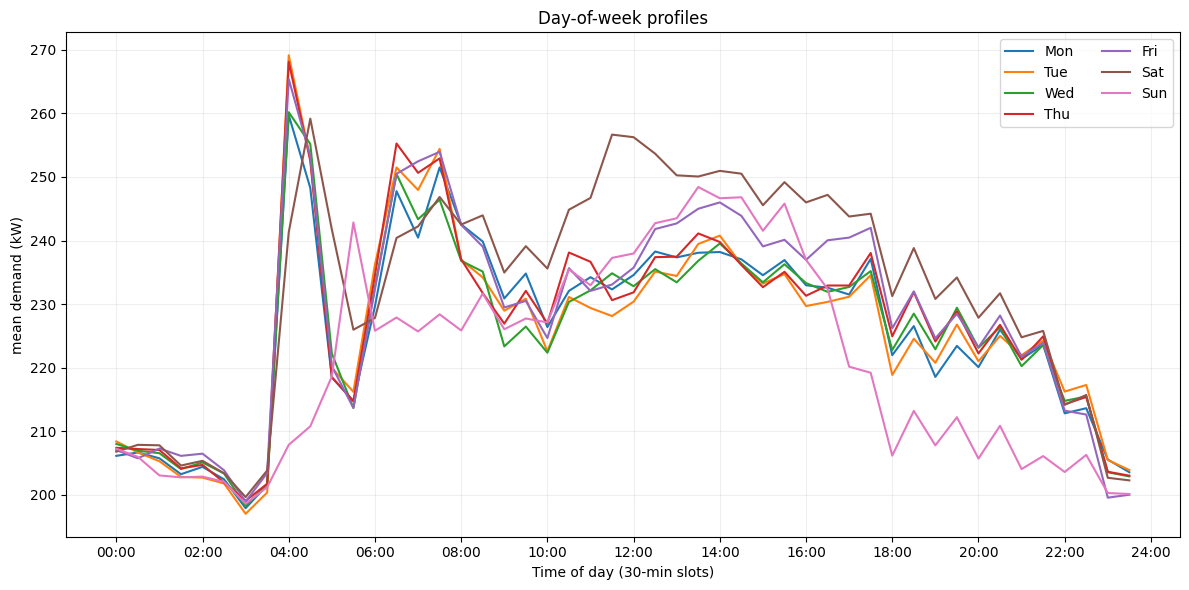

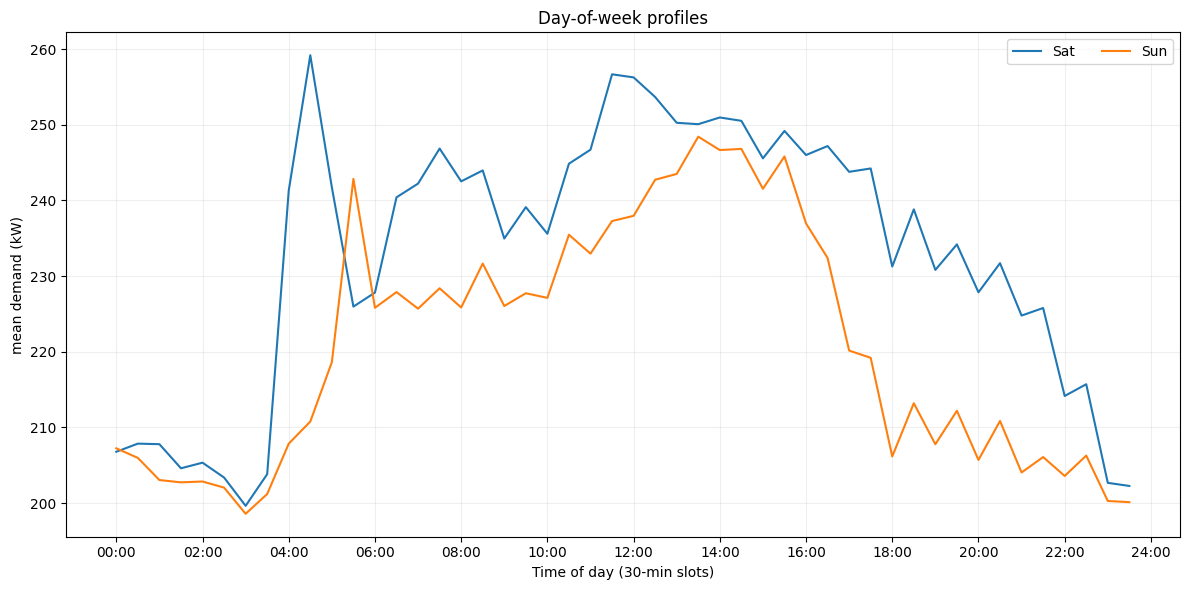

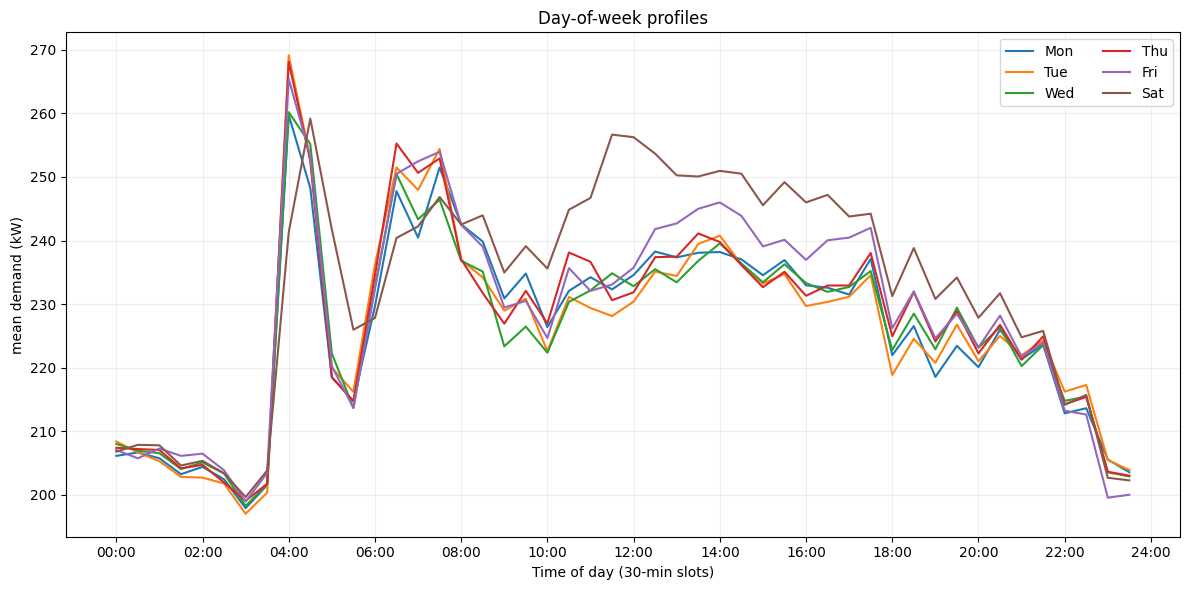

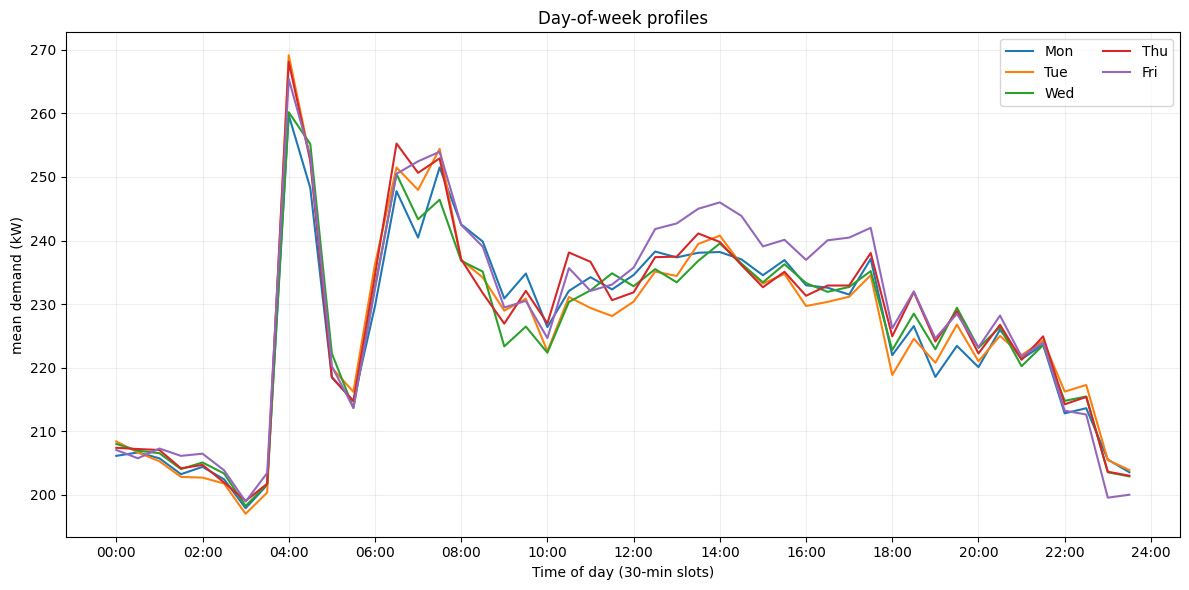

In [8]:
def plot_day_of_week_profiles(df, demand_col=DEMAND_COL,dows=range(7),agg='mean', figsize=(12,6)):
    prof = d.groupby(["dayofweek","slot"])[demand_col].agg(agg).reset_index()
    labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    plt.figure(figsize=figsize)
    for dow in dows:
        sub = prof[prof["dayofweek"]==dow]
        plt.plot(sub["slot"], sub[demand_col], label=labels[dow])
    plt.xticks(range(0,49,4), [f"{h:02d}:00" for h in range(0,25,2)])
    plt.xlabel("Time of day (30-min slots)")
    plt.ylabel(f"{agg} demand (kW)")
    plt.title("Day-of-week profiles")
    plt.legend(ncol=2)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

plot_day_of_week_profiles(d)
plot_day_of_week_profiles(d, dows=(5,6))
plot_day_of_week_profiles(d, dows=range(6))
plot_day_of_week_profiles(d, dows=range(5))

##### Lag autocorrelation observations

- The strongest correlation occurs at **lag 1**, meaning the previous 30-minute period is the most informative predictor of current demand.
- **lag 48** also shows very high autocorrelation (≈0.76), reflecting a strong **daily periodic structure**. i.e. the site behaves similarly at the same time on consecutive days.
- **lags 2–7** steadily decline but remain strongly positive, indicating short-term persistence in demand.
- **lags 96, 144, 192** (2, 3 and 4 days) also appear, confirming weaker weekly structure layered on top of the dominant daily cycle.
- High values across the top 3 lags (e.g., lag1, lag2, lag48) suggest that  they could be informative informative and appropriate model inputs.


In [9]:
def lag_correlations(df, lags=(1,2,48), demand_col=DEMAND_COL, sort_by_abs=True):
    s = df[demand_col].dropna()
    rows = []
    for lag in lags:
        val = s.autocorr(lag=lag)
        rows.append({"lag": int(lag), "autocorr": val, "abs_autocorr": (abs(val) if pd.notna(val) else None)})
    res = pd.DataFrame(rows).set_index("lag")
    return res


lags = list(range(1,48*7)) 
lag_df = lag_correlations(d, lags=lags).sort_values("abs_autocorr", ascending=False)
lag_df.head(10)



,autocorr,abs_autocorr
lag,,
1,0.833203,0.833203
48,0.764966,0.764966
2,0.703939,0.703939
96,0.693348,0.693348
49,0.686966,0.686966
47,0.679026,0.679026
4,0.676257,0.676257
3,0.664016,0.664016
5,0.654042,0.654042


### Frequency of daily peak demand

- Across almost all days, the highest demand occurs between **04:00–05:00**, with a majority clustering in the 04:00 slot.
- After 05:00 the distribution flattens considerably, and peak occurrences outside the early morning period are rare.
- Consistent operational ramp-up period, likely due to scheduled activity or equipment start-up.
- The strong daily periodicity, should use of lag features and time-of-day encodings in the forecasting model.


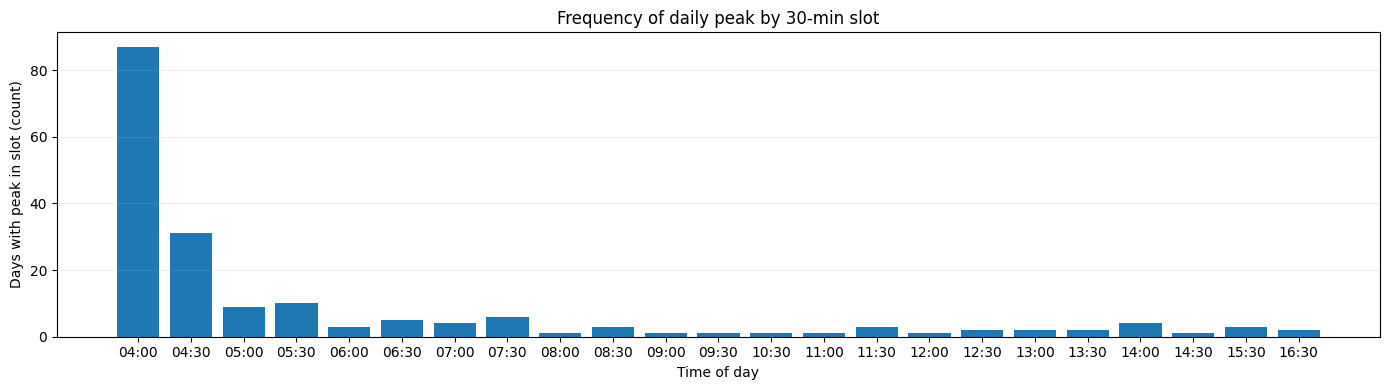

In [10]:
def peak_slot_freq(df, top_n=5, demand_col=DEMAND_COL):
    def peak_slot(g):
        if g.empty: return np.nan
        return int(g.loc[g[demand_col].idxmax(),"slot"])
    peaks = d.groupby(pd.Grouper(freq="D")).apply(peak_slot).dropna().astype(int)
    vals, counts = np.unique(peaks.values, return_counts=True)
    res = pd.DataFrame({
        "slot": vals,
        "time": [f"{s//2:02d}:{(s%2)*30:02d}" for s in vals],
        "count": counts
    }).sort_values("count", ascending=False).reset_index(drop=True)
    return res.head(top_n)


peaks = peak_slot_freq(d, top_n=48).sort_values('slot').reset_index(drop=True)
plt.figure(figsize=(14,4))
plt.bar(peaks['time'], peaks['count'], color='C0')
plt.xlabel('Time of day')
plt.ylabel('Days with peak in slot (count)')
plt.title('Frequency of daily peak by 30-min slot')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

##### Demand Variability (Standard Deviation) by Time of Day

- Overnight demand (00:00–04:00) is the most predictable, with very low variance.
- Variability spikes sharply during the 04:00–06:00 ramp-up period.
- Midday demand is relatively stable (moderate variance, ~20–24 kW).
- Evening decline (18:00–22:00) shows increased variation as activity winds down.

This confirms that the largest prediction uncertainty is linked to changes in operational mode, not steady consumption periods.


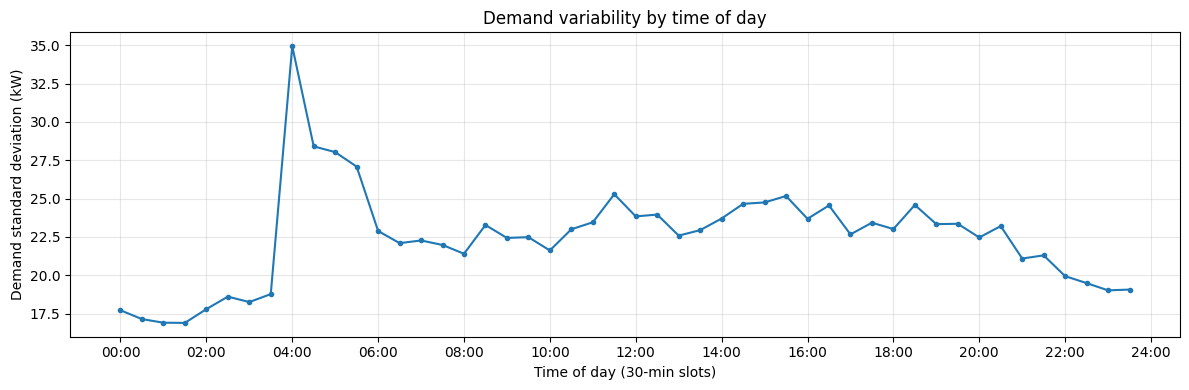

In [11]:
def variance_by_slot(df, demand_col=DEMAND_COL):
    agg = d.groupby("slot")[demand_col].agg(["std"]).reset_index()
    agg["time"] = agg["slot"].apply(lambda s: f"{s//2:02d}:{(s%2)*30:02d}")
    return agg

agg = variance_by_slot(d).sort_values('slot').reset_index(drop=True)


plt.figure(figsize=(12,4))
plt.plot(agg['slot'], agg['std'], '-o', markersize=3)
plt.xticks(range(0,49,4), [f"{h:02d}:00" for h in range(0,25,2)])
plt.xlabel('Time of day (30-min slots)')
plt.ylabel('Demand standard deviation (kW)')
plt.title('Demand variability by time of day')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


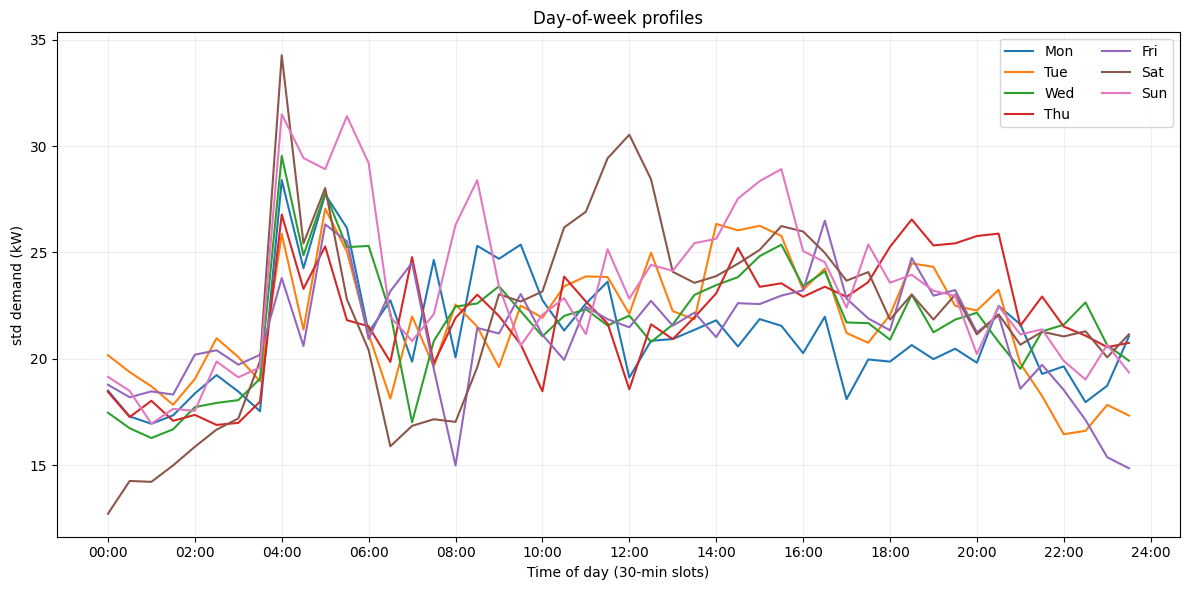

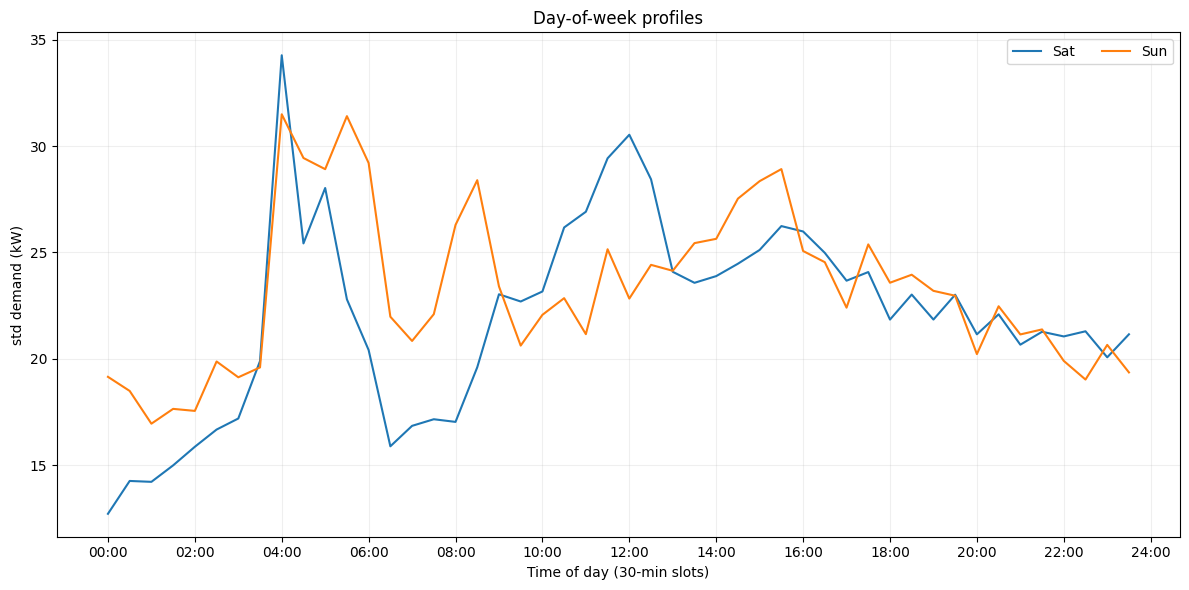

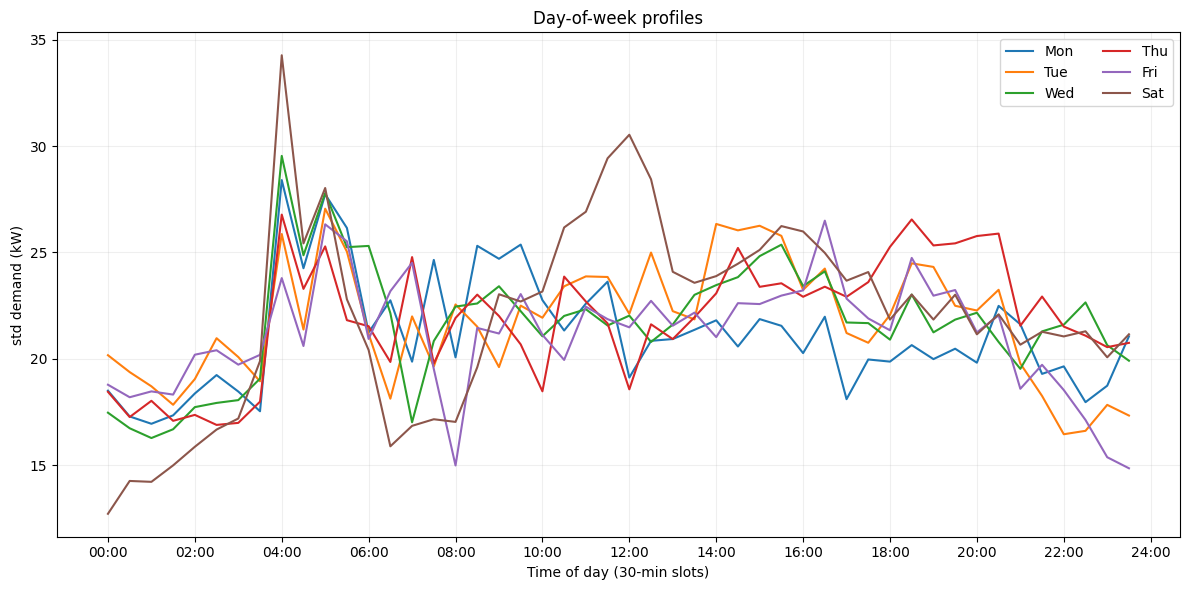

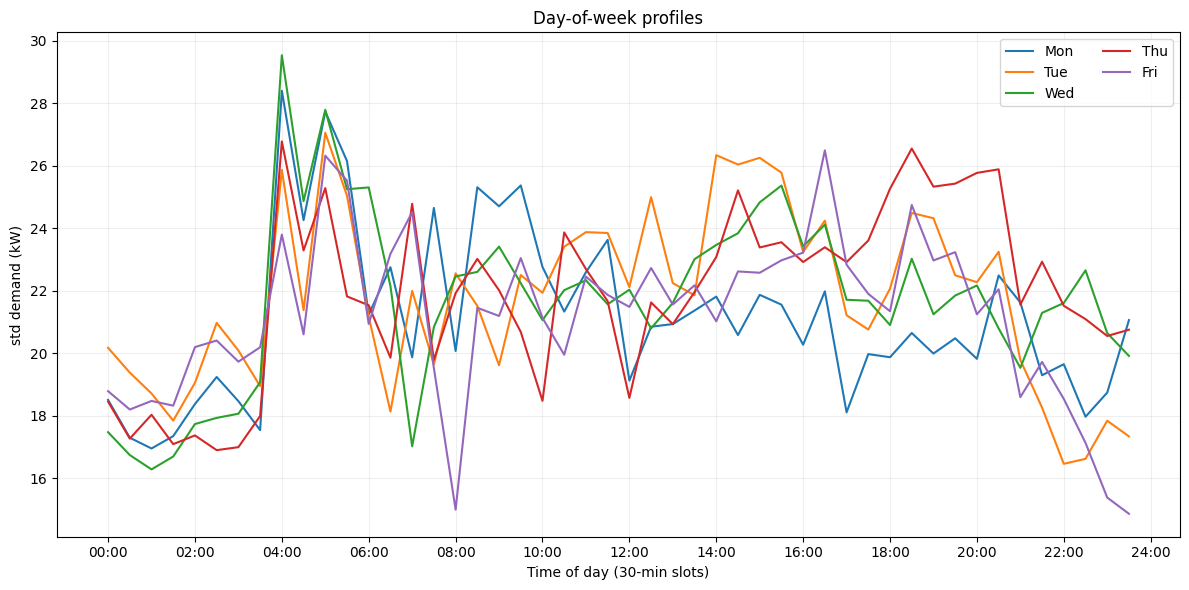

In [12]:
plot_day_of_week_profiles(d, agg='std')
plot_day_of_week_profiles(d, dows=(5,6),agg='std')
plot_day_of_week_profiles(d, dows=range(6), agg='std')
plot_day_of_week_profiles(d, dows=range(5), agg='std')

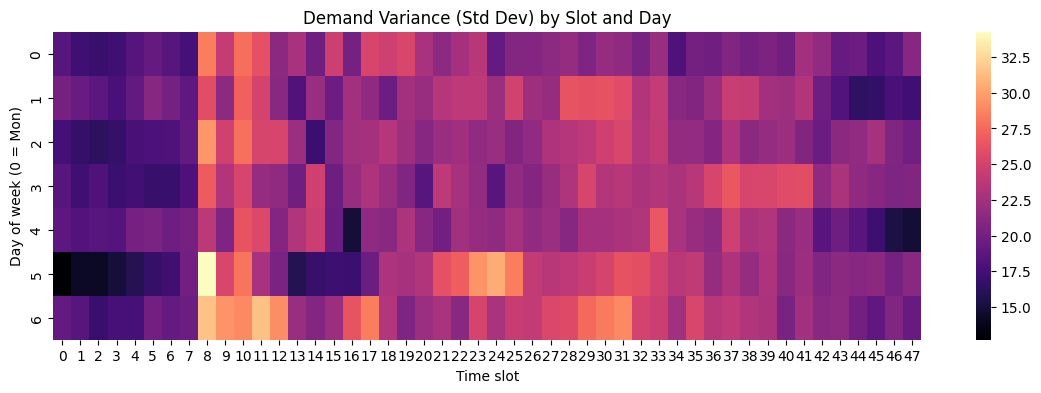

In [13]:
std_mat = d.groupby(["dayofweek","slot"])["mean_demand_kw"].std().unstack()

plt.figure(figsize=(14,4))
sns.heatmap(std_mat, cmap="magma", annot=False)
plt.title("Demand Variance (Std Dev) by Slot and Day")
plt.xlabel("Time slot")
plt.ylabel("Day of week (0 = Mon)")
plt.show()


- Most volatile around 4am
- More volatile in moring and afternoons
- Weekends more volatile than Weekdays

##### Rolling Averages

- 24-hour rolling mean (orange) smooths noise and reveals daily baseline behaviour.

- 7-day rolling mean (green) exposes slow structural shifts, reducing weekday/weekend effects.

- These should hopefully help provide a helpful anchoring signal of recent history.

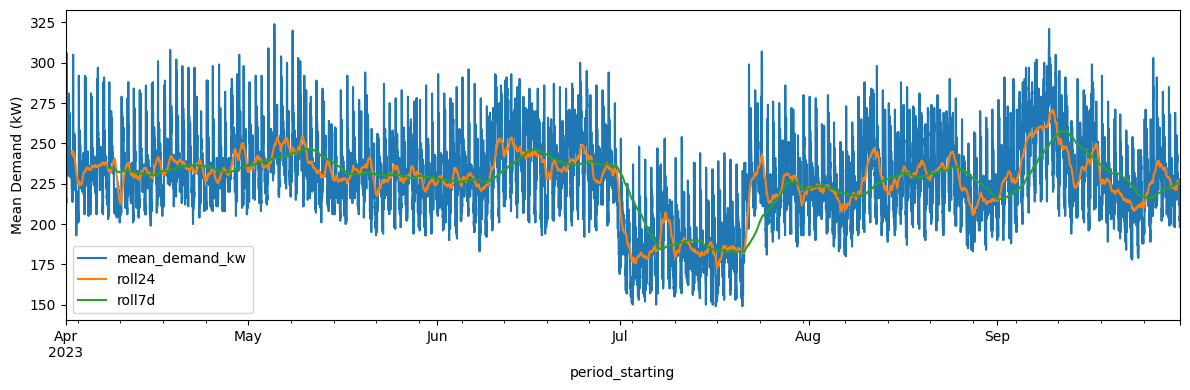

In [14]:
d['roll24'] = d['mean_demand_kw'].rolling(48).mean()
d['roll7d'] = d['mean_demand_kw'].rolling(48*7).mean()

ax = d[['mean_demand_kw', 'roll24', 'roll7d']].plot(figsize=(12,4))
plt.ylabel('Mean Demand (kW)')
plt.tight_layout()
plt.show()

## Forecasting Demand

### Model choice: XGBoost

The demand series shows three strong signals:
1. Short-term persistence (high autocorrelation at lag 1–2).
2. A repeatable daily pattern (strong correlation at lag 48).
3. Weekday/weekend differences.

Because these effects are non-linear and interact (e.g. “04:00 on Saturday behaves differently from 04:00 on Tuesday”), a tree-based model is suitable.

XGBoost was chosen because:
- It handles **non-linear relationships** between time features (slot, day-of-week) and demand.
- It works well with **tabular, engineered features** such as lags and rolling means.
- It requires **minimal preprocessing** and no scaling.

Compared with a Random Forest, XGBoost is better suited to this dataset because boosting learns from previous errors and can focus capacity on the most difficult parts of the signal, such as the volatile morning ramp and weekend daytime behaviour. Random Forests tend to average these fluctuations, which can smooth away sharp transitions and reduce accuracy in periods where demand changes rapidly. Since the strongest variation in this series is localised rather than uniform, a boosted model provides a more appropriate inductive bias than a bagging-based approach.

As requested, no hyperparameter tuning is performed. The goal is to produce a
reasonable baseline model that can be explained and improved in later stages.

#### Selected Features

- **Time-of-day (slot 0–47):** captures the strong daily cycle seen in the data, including the early morning ramp and stable daytime load.  
- **Day-of-week (one-hot):** differentiates weekday behaviour from weekends, where demand is less predictable.  
- **Lag features (lag1, lag2, lag48):** capture short-term persistence and the repeated daily pattern (lag48 shows the highest non-trivial autocorrelation).  
- **Rolling averages (roll24, roll7d):** provide context on recent demand levels and smooth short-term noise, helping the model handle gradual changes.


In [15]:
def create_model_features(df,
                          demand_col='mean_demand_kw',
                          window_24=48,
                          window_7d=48*7,
                          dropna=False):
    """
    Return a copy of df with model features:
      - slot (0..47)
      - dayofweek (0..6) + one-hot columns dayofweek_0..dayofweek_6
      - lag1, lag2, lag48
      - roll24, roll7d

    If the DataFrame does not have a DatetimeIndex, function will use datetime_col and set it.
    Set dropna=True to drop rows missing lag/rolling features (usually the first rows).
    """
    d = df.copy()

    # slot and dayofweek
    d['slot'] = d.index.hour * 2 + (d.index.minute // 30)
    d['dayofweek'] = d.index.dayofweek

    # one-hot dayofweek (keeps all 7 columns)
    dummies = pd.get_dummies(d['dayofweek'], prefix='dayofweek', drop_first=False)
    d = pd.concat([d, dummies], axis=1)

    # lags
    d['lag1']  = d[demand_col].shift(1)
    d['lag2']  = d[demand_col].shift(2)
    d['lag48'] = d[demand_col].shift(window_24)

    # rolling means
    d['roll24'] = d[demand_col].rolling(window_24).mean()
    d['roll7d']  = d[demand_col].rolling(window_7d).mean()

    if dropna:
        d = d.dropna(subset=['lag1', 'lag2', 'lag48', 'roll24', 'roll7d'])
    d = d.drop(columns=['dayofweek'])
    return d


### Train / validation / test splits

I use time-based splits to avoid look-ahead bias:

- **Training:** all data up to **2023-09-15**  
- **Validation:** **2023-09-15 → 2023-09-30**  
- **Test:** **2023-09-30 onwards** (the final day before the forecast horizon)

This ensures that:
- The model is always trained on the past and evaluated on the future, which matches the real forecasting setting.
- The validation window is close in time to the test/forecast period, so it reflects the most recent behaviour of the site.
- Most of the historical data is used for training, while still holding out enough recent data to assess generalisation and compare against the naïve baseline.


In [16]:
data_df=create_model_features(demand_df)
cut1 = '2023-09-15'
cut2 = '2023-09-30'

train_df = data_df[data_df.index < cut1]
valid_df = data_df[(data_df.index >= cut1) & (data_df.index < cut2)]
test_df  = data_df[data_df.index >= cut2]

In [17]:
y_col='mean_demand_kw'

X_train = train_df.drop(columns=[y_col])
y_train = train_df[y_col]

X_valid = valid_df.drop(columns=[y_col])
y_valid = valid_df[y_col]

X_test = test_df.drop(columns=[y_col])
y_test = test_df[y_col]

print("shapes:", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

shapes: (8016, 13) (8016,) (720, 13) (720,) (48, 13) (48,)


#### Train Model

In [18]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=.1,
    reg_alpha=.1,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50, 
    random_state=42,
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False,
)




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

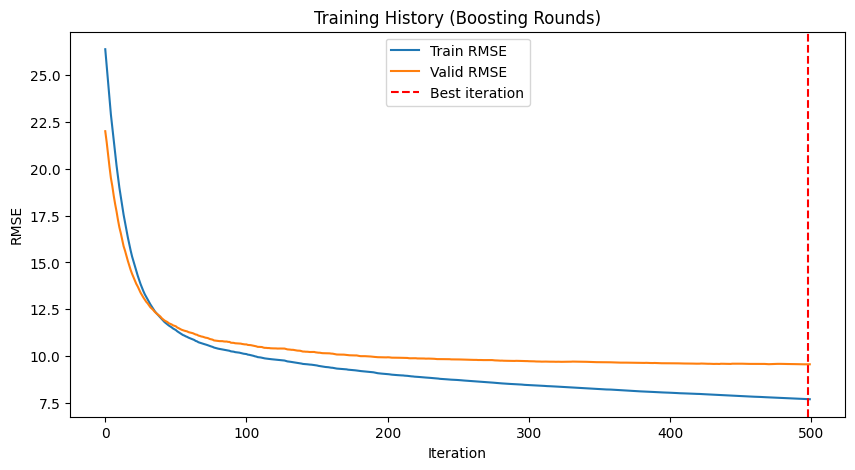

In [19]:
results = model.evals_result()

train_rmse = results['validation_0']['rmse']
valid_rmse = results['validation_1']['rmse']

plt.figure(figsize=(10,5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Valid RMSE')
plt.axvline(model.best_iteration, color='red', linestyle='--', label='Best iteration')
plt.title("Training History (Boosting Rounds)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()
plt.show()


#### Predict and Evaluate

In [20]:
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

In [21]:
#XGBoost model
rmse_valid = root_mean_squared_error(y_valid, y_pred_valid)
rmse_test  = root_mean_squared_error(y_test, y_pred_test)

mae_valid = mean_absolute_error(y_valid, y_pred_valid)
mae_test  = mean_absolute_error(y_test, y_pred_test)


In [22]:
naive_prev_slot_valid = X_valid['lag1']
naive_prev_slot_test  = X_test['lag1']

naive_prev_day_valid = X_valid['lag48']
naive_prev_day_test  = X_test['lag48']

# Errors for prev-slot naive
rmse_naive_prev_slot_valid = root_mean_squared_error(y_valid, naive_prev_slot_valid)
rmse_naive_prev_slot_test  = root_mean_squared_error(y_test,  naive_prev_slot_test)
mae_naive_prev_slot_valid  = mean_absolute_error(y_valid, naive_prev_slot_valid)
mae_naive_prev_slot_test   = mean_absolute_error(y_test,  naive_prev_slot_test)

# Errors for prev-day naive
rmse_naive_prev_day_valid = root_mean_squared_error(y_valid, naive_prev_day_valid)
rmse_naive_prev_day_test  = root_mean_squared_error(y_test,  naive_prev_day_test)
mae_naive_prev_day_valid  = mean_absolute_error(y_valid, naive_prev_day_valid)
mae_naive_prev_day_test   = mean_absolute_error(y_test,  naive_prev_day_test)


In [23]:

# Summary table with both naive baselines
df_results = pd.DataFrame({
    "metric": ["RMSE Valid", "RMSE Test", "MAE Valid", "MAE Test"],
    "model": [rmse_valid, rmse_test, mae_valid, mae_test],
    "naive_prev_slot": [
        rmse_naive_prev_slot_valid, rmse_naive_prev_slot_test,
        mae_naive_prev_slot_valid, mae_naive_prev_slot_test
    ],
    "naive_prev_day": [
        rmse_naive_prev_day_valid, rmse_naive_prev_day_test,
        mae_naive_prev_day_valid, mae_naive_prev_day_test
    ]
}).set_index("metric")

In [24]:
display(
    df_results.style
        .format("{:.3f}")
        .background_gradient(cmap="RdYlGn_r", axis=1)  # reversed so green = small values
        .set_table_styles([{"selector": "th", "props": "text-align:center;"}])
)


,model,naive_prev_slot,naive_prev_day
metric,,,
RMSE Valid,9.556,16.591,17.693
RMSE Test,6.500,11.524,18.694
MAE Valid,6.910,10.769,13.113
MAE Test,4.921,7.792,13.229


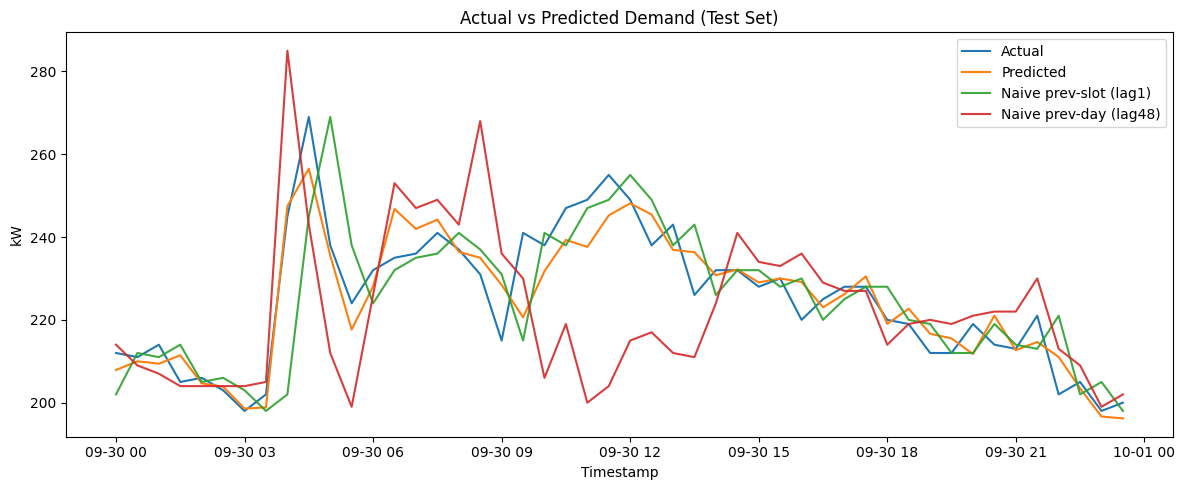

In [25]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual', color='C0')
plt.plot(y_test.index, y_pred_test, label='Predicted', color='C1')
plt.plot(y_test.index, naive_prev_slot_test, label='Naive prev-slot (lag1)', color='C2', alpha=0.9)
plt.plot(y_test.index, naive_prev_day_test,  label='Naive prev-day (lag48)', color='C3', alpha=0.9)
plt.title("Actual vs Predicted Demand (Test Set)")
plt.xlabel("Timestamp")
plt.ylabel("kW")
plt.legend()
plt.tight_layout()
plt.show()

#### Why the model outperformed the naive benchmarks

- **Naive approaches only look backwards**, either to the previous timestep (lag-1) or the same slot on the previous day (lag-48).  
  They assume demand patterns are locally smooth or strictly daily-repeatable — which is rarely true.

- **The model uses multiple sources of structure**, including:
  - recent short-term behaviour (lag1, lag2)
  - daily cycles (lag48)
  - rolling context (roll24, roll7d)
  - calendar effects (day-of-week)

- **Morning spikes and transitional periods are not predictable from a single lag**, and naive forecasts struggle there.  
  The model recognises these patterns because tree splits combine time-of-day with lagged demand.

- **Demand is not perfectly repeatable day-to-day**, so lag-48 performs worst.  
  The model captures weekday vs weekend differences and seasonal shifts, reducing this error.

**In short:**  
The model outperforms naive benchmarks because it leverages richer temporal context and non-linear interactions, while naive rules rely on a single past observation.


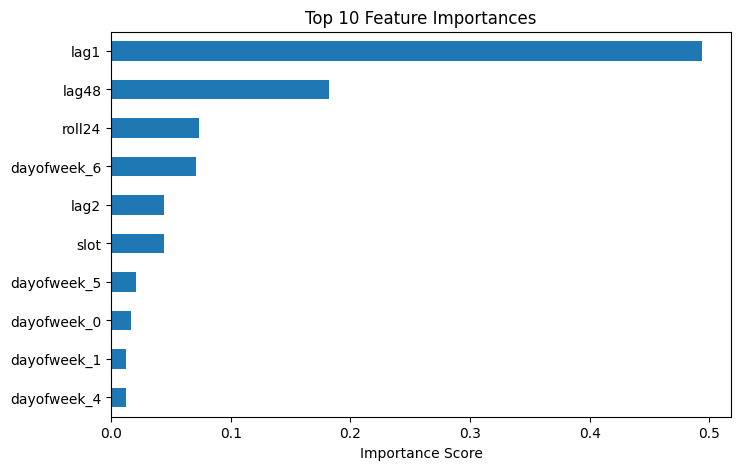

In [26]:
importance = pd.Series(model.feature_importances_, index=X_train.columns)
imp = importance.sort_values().tail(10)

plt.figure(figsize=(8,5))
imp.plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


### Create Forecast

In [27]:

# 48 future half-hour timestamps
last_ts = data_df.index.max()
future_ts = pd.date_range(last_ts + pd.Timedelta(minutes=30),
                          periods=48,
                          freq='30min')


hist_series = data_df['mean_demand_kw'].copy()

forecasts = []


# Has to be done iteratively because of lag and rolling average features
for ts in future_ts:
    # ---- Time-based features ----
    slot = ts.hour * 2 + (ts.minute // 30)
    dow = ts.dayofweek
    
    row = {}
    row['slot'] = slot
    
    # one-hot dayofweek_0..6
    for d in range(7):
        row[f'dayofweek_{d}'] = 1 if d == dow else 0

    # ---- Lag features ----
    row['lag1']  = hist_series.iloc[-1]
    row['lag2']  = hist_series.iloc[-2]
    row['lag48'] = hist_series.iloc[-48]

    # ---- Rolling windows ----
    row['roll24'] = hist_series.rolling(48).mean().iloc[-1]
    row['roll7d'] = hist_series.rolling(48*7).mean().iloc[-1]

    # Build feature row in correct column order
    X_row = pd.DataFrame([row], columns=X_train.columns)
    
    # Predict one step
    pred_val = model.predict(X_row)[0]
    
    # Append to forecast + history so next step can use lags
    forecasts.append((ts, pred_val))
    hist_series.loc[ts] = pred_val

# Final forecast df for battery step
forecast_df = pd.DataFrame(forecasts, columns=['period_starting', 'mean_demand_kw'])
forecast_df.set_index('period_starting', inplace=True)

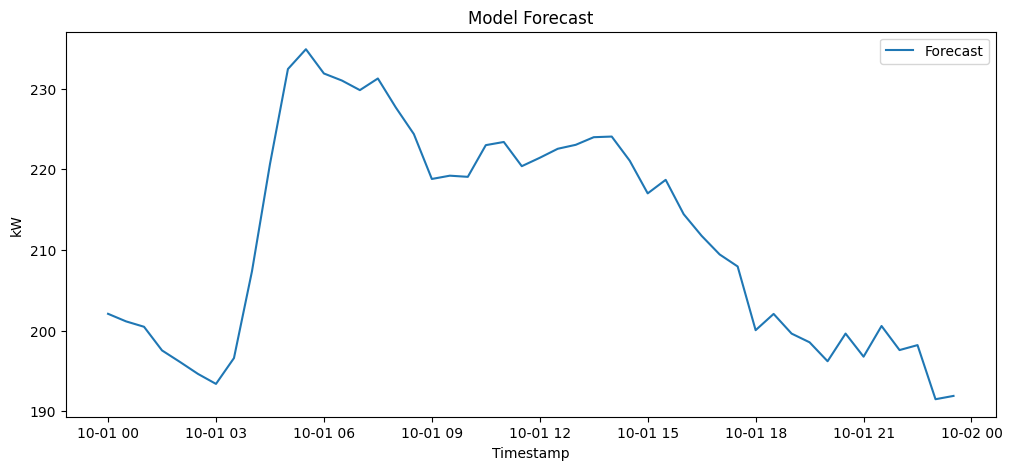

In [28]:
plt.figure(figsize=(12,5))
plt.plot(forecast_df.index, forecast_df['mean_demand_kw'], label='Forecast')
plt.title("Model Forecast")
plt.xlabel("Timestamp")
plt.ylabel("kW")
plt.legend()
plt.show()

## Battery optimisation

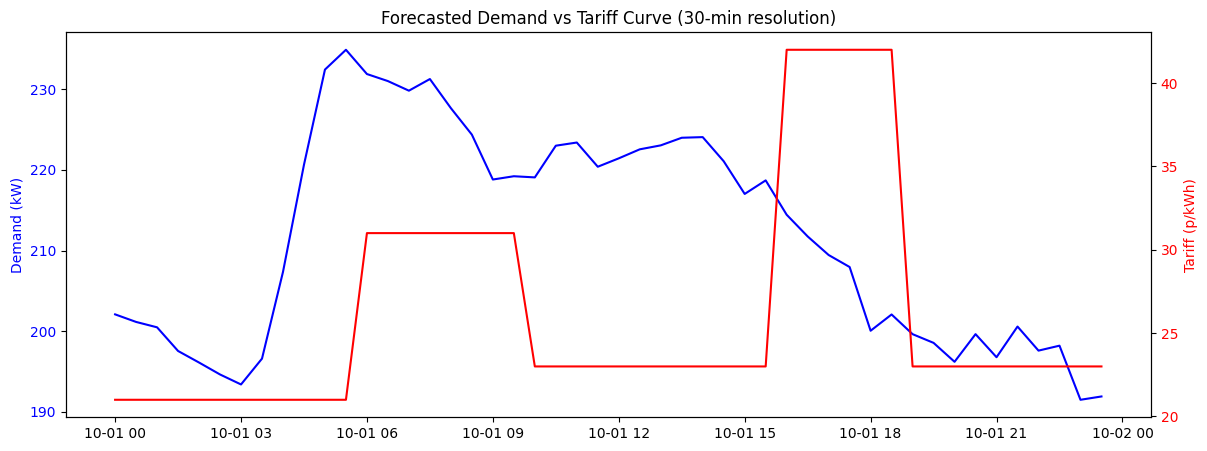

In [29]:
plt.figure(figsize=(14,5))
ax1 = plt.gca()

# Demand forecast
ax1.plot(
    forecast_df.index,
    forecast_df['mean_demand_kw'],
    color='b',
    label='Forecast Demand (kW)'
)
ax1.set_ylabel('Demand (kW)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Second axis for tariff
ax2 = ax1.twinx()
ax2.plot(
    tariff_df.index,
    tariff_df['price_pence_per_kwh'],
    color='r',
    label='Tariff (p/kWh)'
)
ax2.set_ylabel('Tariff (p/kWh)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Forecasted Demand vs Tariff Curve (30-min resolution)")
plt.xlabel("Time")
plt.show()


In [30]:
# 1. Merge forecasted demand + price

df = forecast_df[['mean_demand_kw']].merge(
    tariff_df[['price_pence_per_kwh']],
    left_index=True,
    right_index=True
)

df['price_gbp_per_kwh'] = df['price_pence_per_kwh'] / 100

In [31]:
# =============================
# BATTERY PARAMETERS
# =============================
MAX_POWER_KW = 220           # max charge/discharge
CAPACITY_KWH = 440           # battery size
INITIAL_SOC = 220            # half full
INTERVAL_HOURS = 0.5         # 30 min resolution
MAX_STEP_ENERGY = MAX_POWER_KW * INTERVAL_HOURS  # 110 kWh


T = len(df)
dt = 0.5

price = df['price_gbp_per_kwh'].values
demand = df['mean_demand_kw'].values

# decision variables
c = cp.Variable(T, nonneg=True)  # charge
d = cp.Variable(T, nonneg=True)  # discharge
g = cp.Variable(T, nonneg=True)  # grid import
s = cp.Variable(T+1)             # SoC

constraints = []

# initial SoC
constraints += [s[0] == INITIAL_SOC]

for t in range(T):
    # battery evolution
    constraints += [
        s[t+1] == s[t] + (c[t] - d[t]) * dt
    ]
    # capacity limits
    constraints += [
        s[t+1] >= 0,
        s[t+1] <= CAPACITY_KWH
    ]
    # charge/discharge limits
    constraints += [
        c[t] <= MAX_POWER_KW,
        d[t] <= MAX_POWER_KW
    ]

    # no export
    constraints += [
        g[t] == demand[t] + c[t] - d[t],
        g[t] >= 0
    ]

# objective: minimize total cost
objective = cp.Minimize(cp.sum(cp.multiply(price, g) * dt))

problem = cp.Problem(objective, constraints)
problem.solve()

df['opt_charge_kw'] = c.value
df['opt_discharge_kw'] = d.value
df['opt_grid_kw'] = g.value
df['opt_soc'] = s.value[1:]


### State of energy of battery

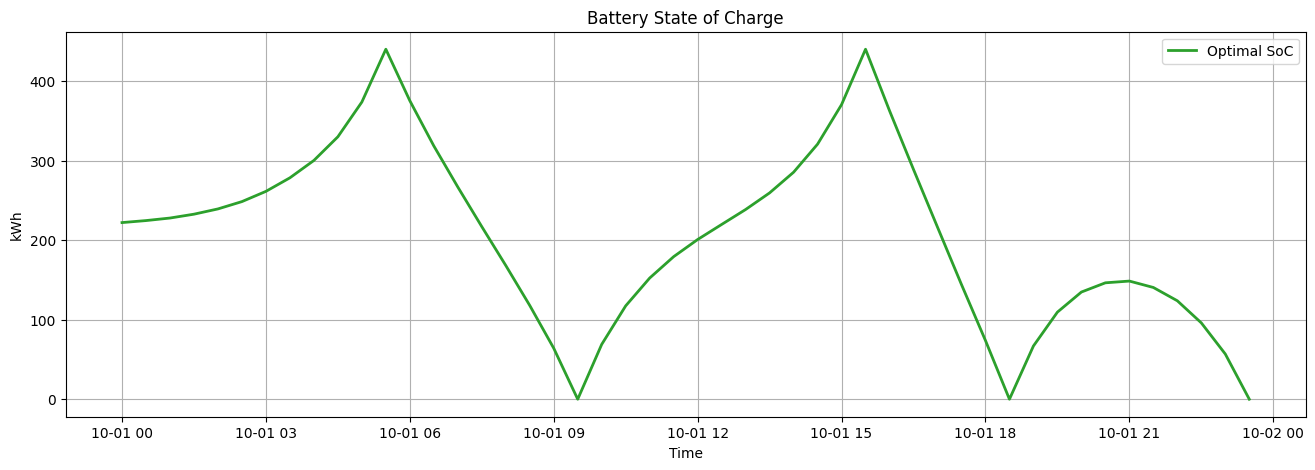

In [32]:
plt.figure(figsize=(16,5))

plt.plot(df.index, df['opt_soc'], label="Optimal SoC", color="tab:green", linewidth=2)

plt.title("Battery State of Charge")
plt.ylabel("kWh")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()


### Cost Savings

In [33]:
df['opt_cost'] = df['opt_grid_kw'] * df['price_gbp_per_kwh'] * INTERVAL_HOURS
opt_total_cost = df['opt_cost'].sum()

df['cost_no_batt'] = df['mean_demand_kw'] * df['price_gbp_per_kwh'] * INTERVAL_HOURS
total_no = df['cost_no_batt'].sum()

opt_savings = total_no - opt_total_cost


print(f"🟢 Optimal savings: £{opt_savings:,.2f}")

🟢 Optimal savings: £173.80


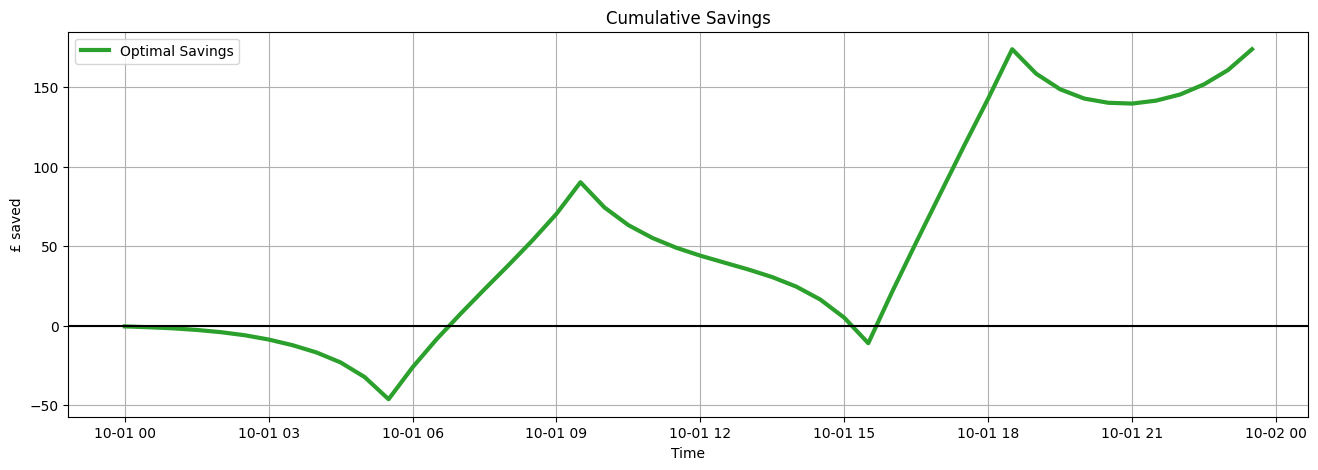

In [34]:
plt.figure(figsize=(16,5))

plt.plot(df.index, (df['cost_no_batt'] - df['opt_cost']).cumsum(),
         label='Optimal Savings', color='tab:green', linewidth=3)

plt.axhline(0, color='black')
plt.title("Cumulative Savings")
plt.ylabel("£ saved")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()


The optimiser follows a classic price-arbitrage strategy. The battery charges aggressively during low-tariff periods, even when demand is rising, because the objective is cost minimisation rather than demand smoothing. When prices first increase (≈06:00–10:00), the battery discharges to reduce grid import, then recharges throughout the cheaper midday period. The most valuable discharge happens during the evening peak (≈16:00–19:00), where tariffs are highest. The optimiser empties the battery to avoid buying expensive energy. 

Towards the end of the optimisation window the battery SoC drops sharply to zero. 
This behaviour is expected in a finite-horizon optimisation: since there is no 
future value assigned to remaining energy after the final timestamp, the solver 
has no incentive to retain charge. The model therefore discharges any remaining 
energy to offset grid import before the horizon ends, reducing cost in the final 
periods.

Across the full day, this behaviour materially flattens grid import during expensive periods and shifts energy consumption into cheap tariff windows. The result is that storage is used as intended: **buy low, store, and offset demand when prices are high**, delivering **£173.80** in savings versus a passive grid-only strategy.
